# Fig: lifetime vs. mse

**Motivation**: aka rate-distortion. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _get_df2p(dfs):
    
    # mse scores
    df_mse = dfs['main'].copy()
    df_mse = df_mse.loc[
        (df_mse['enc_type'] == 'conv') &
        (df_mse['dataset'] == 'DOVES') &
        (df_mse['method'] == 'mc')
    ].reset_index(drop=True)
    
    # lifetime scores
    df_sprs = dfs['lifetime'].copy()
    df_sprs = df_sprs.loc[
        (df_sprs['enc_type'] == 'conv') &
        (df_sprs['dataset'] == 'DOVES') &
        (df_sprs['method'] == 'mc')
    ].reset_index(drop=True)
    df_sprs = df_sprs.groupby(by=['type', 'seed']).mean(
        numeric_only=True)['lifetime'].reset_index()

    # create df2p
    df2p = collections.defaultdict(list)
    looper = itertools.product(
        df_mse['type'].unique(),
        df_mse['seed'].unique(),
    )
    for mod, s in looper:
        vals = {
            'type': mod,
            'seed': s,
        }
        vals['mse_map'] = df_mse.loc[
            (df_mse['seed'] == s) &
            (df_mse['type'] == mod),
            'mse_map',
        ].item()
        vals['lifetime'] = df_sprs.loc[
            (df_sprs['seed'] == s) &
            (df_sprs['type'] == mod),
            'lifetime',
        ].item()
        for k, v in vals.items():
            df2p[k].append(v)
    df2p = pd.DataFrame(df2p)

    # load lca / ista
    df_sc = dfs['sc'].copy()
    df_sc = df_sc.loc[df_sc['quality'] == 'best']
    df_sc = df_sc[['type', 'seed', 'mse_map', 'lifetime']]

    # add lca / ista
    df2p = pd.concat([
        df2p,
        df_sc,
    ]).reset_index(drop=True)
    
    return df2p


def sigmoid_beta_linear(x):
    L, x0, k, b = [
        0.72930579,
        0.76495883,
        3.39020406,
        0.27468761,
    ]
    y = L / (1 + np.exp(-k*(x / 100 - x0))) + b
    return (y)


def sigmoid_lca_poisson(x):
    L, x0, k, b = [
        2.53656547e+02,
        1.56483081e+00,
        1.84206981e-01,
        -2.52717804e+02,
    ]
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y

In [3]:
# HIDE CODE


def scatter_plot_vae():
    fig, ax = create_figure(1, 1, (8, 4.5))
    sns.scatterplot(
        data=df2p.loc[df2p['type'].isin(hue_order)],
        x='mse_map',
        y='lifetime',
        hue='type',
        palette=pal,
        hue_order=hue_order,
        alpha=0.9,
        s=200,
        ax=ax,
    )
    for artist in ax.collections:
        c = artist.get_facecolor()
        artist.set_edgecolor(c)
        artist.set_facecolor('none')
        artist.set_lw(1.8)
    ax.grid()
    
    # add line plot
    xs = np.linspace(0, 245, 10000)
    ys = sigmoid_beta_linear(xs)
    
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(ys.min(), ys.max())
    
    lc = LineCollection(
        segments,
        norm=norm,
        cmap='crest',
        linewidth=3,
        alpha=0.6,
        linestyle='--',
    )
    lc.set_array(ys)
    ax.add_collection(lc)
    
    # add beta crosses
    sns.scatterplot(
        data=df2p_linbeta,
        x='mse_map',
        y='lifetime',
        hue='beta',
        palette=pal_beta,
        legend=True,
        alpha=1.0,
        s=100,
        ax=ax,
    )
    
    # final touch
    ax.autoscale()
    ax.set_ylim(0.3, 1.03)
    ax.set_xlim(right=250)
    ax.set(xlabel='', ylabel='')
    ax.tick_params(axis='both', labelsize=15)
    
    # legend
    sns.move_legend(ax, loc='lower right', fontsize=12.0)
    legend = ax.get_legend()
    legend.set_title('')
    
    for handle in legend.legendHandles:
        handle.set_sizes([handle.get_sizes()[0] * 3.0])
    
    for text in legend.get_texts():
        try:
            float(text.get_text())
        except ValueError:
            continue
    
        b = float(text.get_text())
        text.set_text(r"$\beta = $" + f" {b:0.2f}")
    
    plt.show()

    return fig, ax

## Fig save dir

In [4]:
from matplotlib.collections import LineCollection
from figures.imgs import plot_weights

fig_dir = pjoin(fig_base_dir, 'nips_may22')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'phi_conv_categorical.png',
    'rate_dist_lca.pdf',
    'phi_lca.png',
    'phi_conv_laplace.png',
    'phi_conv_poisson.png',
    'phi_lin_laplace.png',
    'phi_fista.png',
    'phi_conv_gaussian.png',
    'phi_lin_poisson.png',
    'recons_samples',
    'phi_lin_categorical.png',
    'nelbo_point.pdf',
    'phi_lin_gaussian.png',
    'phi_ista.png',
    'dead_kl_gap.pdf',
    'rate_dist_vae.pdf'
]

## Device

In [5]:
device_idx = 1
device = f'cuda:{device_idx}'

## Palette

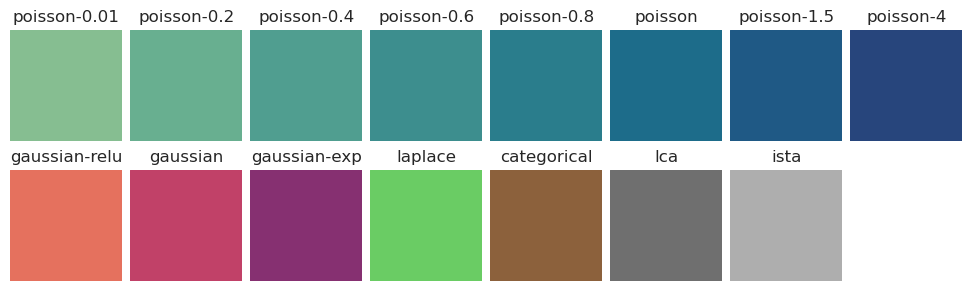

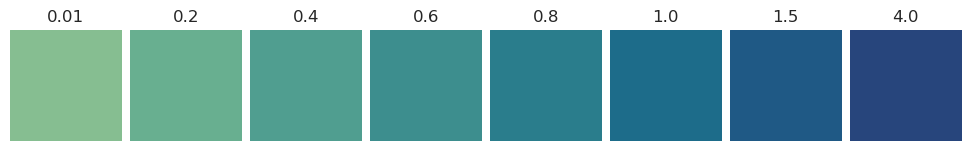

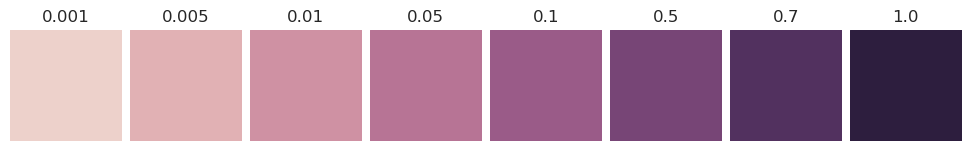

In [6]:
pal, pal_beta, pal_lamb = get_palette()
show_palette(pal)
show_palette(pal_beta)
show_palette(pal_lamb)

## Load dfs

In [7]:
dfs = [
    'main',
    'lifetime',
    'beta_main',
    'beta_lifetime',
]
dfs = {
    k: pd.read_pickle(pjoin(tmp_dir, f"df_{k}.df")).drop(columns=[
        'checkpoint', 'timestamp', 'n_params',
    ]) for k in dfs
}
dfs['sc'] = pd.read_pickle(pjoin(tmp_dir, 'df_sc.df'))
print(list(dfs))

['main', 'lifetime', 'beta_main', 'beta_lifetime', 'sc']

In [8]:
df2p_linbeta = pd.read_pickle(pjoin(tmp_dir, 'df2p_poisson_lin_beta.df'))
df2p_linbeta = df2p_linbeta.groupby(by=['beta']).mean(
    numeric_only=True).reset_index().drop(columns='seed')
df2p_linbeta.shape

(8, 3)

In [9]:
df2p = _get_df2p(dfs)
df2p.shape

(40, 4)

In [10]:
hue_order = [
    'poisson', 'categorical', 'laplace',
    'gaussian', 'gaussian-relu', 'gaussian-exp',
]

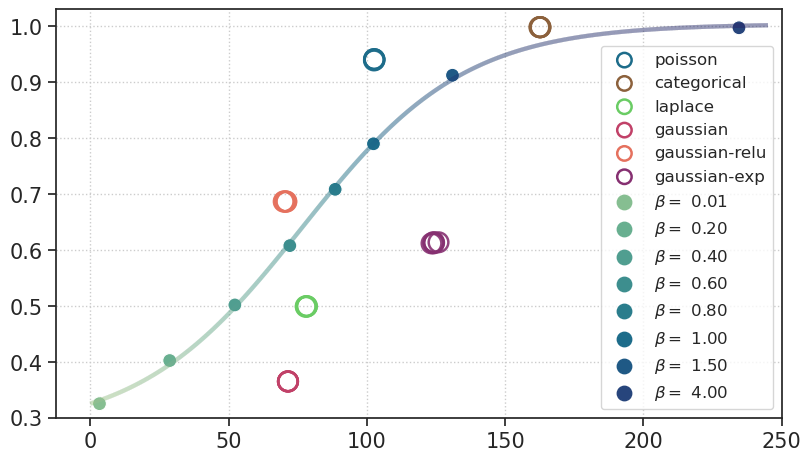

In [11]:
fig, ax = scatter_plot_vae()
fig.savefig(pjoin(fig_dir, 'rate_dist_vae.pdf'), **kws_fig)

In [12]:
df_avg = df2p.groupby('type').mean().drop(columns='seed')
df_avg

,mse_map,lifetime
type,,
categorical,162.610968,0.998082
gaussian,71.492685,0.365007
gaussian-exp,124.380699,0.612849
gaussian-relu,70.474037,0.686514
ista,86.852882,0.961063
laplace,78.136801,0.499070
lca,50.174009,0.917055
poisson,102.678957,0.940106


In [13]:
df_avg.to_excel(pjoin(tmp_dir, 'rate-distort.xlsx'))

## Part II: LCA, ISTA

In [14]:
df2p_lcs_inf = pd.read_pickle(pjoin(tmp_dir, 'df2p_lcs_inf.df'))
df2p_lcs_inf = df2p_lcs_inf.loc[df2p_lcs_inf['vae_source'] == 'poisson']
df2p_lcs_inf.shape

(8, 4)

In [15]:
hue_order = [
    'lca', 'ista', 'poisson',
]

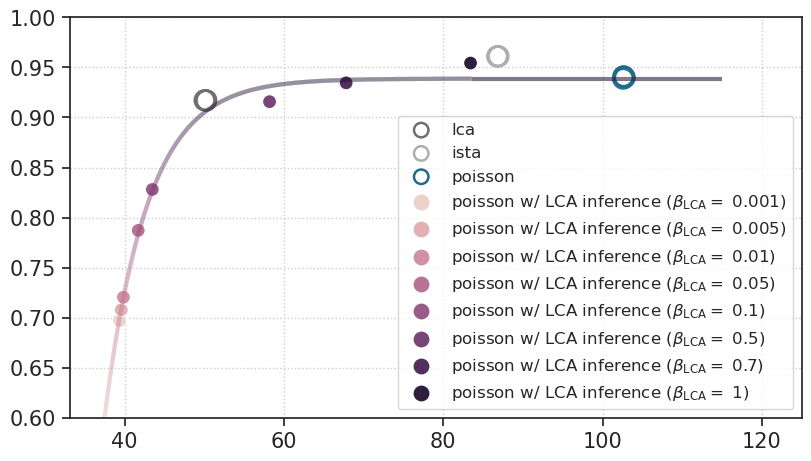

In [27]:
# HIDE CODE


fig, ax = create_figure(1, 1, (8, 4.5))
sns.scatterplot(
    data=df2p.loc[df2p['type'].isin(hue_order)],
    x='mse_map',
    y='lifetime',
    hue='type',
    palette=pal,
    hue_order=hue_order,
    alpha=0.9,
    s=200,
    ax=ax,
)
for artist in ax.collections:
    c = artist.get_facecolor()
    artist.set_edgecolor(c)
    artist.set_facecolor('none')
    artist.set_lw(1.8)
ax.grid()

# add line plot
xs = np.linspace(37, 115, 10000)
ys = sigmoid_lca_poisson(xs)

points = np.array([xs, ys]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(ys.min(), ys.max())

lc = LineCollection(
    segments,
    norm=norm,
    cmap=sns.cubehelix_palette(as_cmap=True),
    linewidth=3,
    alpha=0.6,
    linestyle='--',
)
lc.set_array(ys)
ax.add_collection(lc)

# add beta crosses
sns.scatterplot(
    data=df2p_lcs_inf,
    x='mse_map',
    y='lifetime',
    hue='lamb',
    palette=pal_lamb,
    legend=True,
    s=100,
    ax=ax,
)

# final touch
ax.autoscale()
ax.set_ylim(0.6, 1.0)
ax.set_xlim(right=125)
ax.set(xlabel='', ylabel='')
ax.tick_params(axis='both', labelsize=15)

# legend
sns.move_legend(ax, loc='lower right', fontsize=12.0)
legend = ax.get_legend()
legend.set_title('')

for handle in legend.legendHandles:
    handle.set_sizes([handle.get_sizes()[0] * 3.0])

for text in legend.get_texts():
    try:
        float(text.get_text())
    except ValueError:
        continue

    b = float(text.get_text())
    msg = f"poisson w/ LCA inference ("
    msg += r"$\beta_\text{LCA} = $" + f" {b:0.1g})"
    text.set_text(msg)

plt.show()

In [28]:
fig.savefig(pjoin(fig_dir, 'rate_dist_lca.pdf'), **kws_fig)

## Dont go below

In [2]:
df_lca_inf = pjoin(tmp_dir, 'df_lca_inf.df')
df_lca_inf = pd.read_pickle(df_lca_inf)

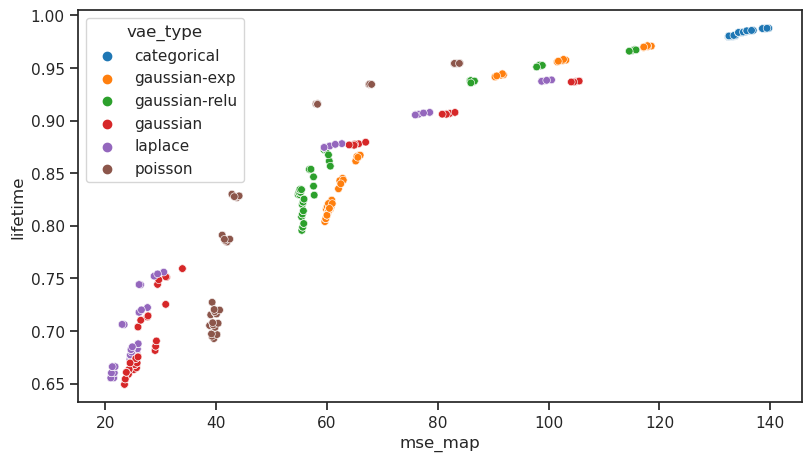

In [3]:
fig, ax = create_figure(1, 1, (8, 4.5))
sns.scatterplot(data=df_lca_inf, x='mse_map', y='lifetime', hue='vae_type', s=30);

In [4]:
df_lca_inf_avg = df_lca_inf.groupby(
    by=['vae_type', 'lamb']).mean(numeric_only=True)
lca_inf_mse = df_lca_inf_avg['mse_map'].reset_index()
lca_inf_lifetime = df_lca_inf_avg['lifetime'].reset_index()

In [5]:
df2p_lcs_inf = collections.defaultdict(list)
for mod in df_lca_inf['vae_type'].unique():
    _df = lca_inf_mse.loc[lca_inf_mse['vae_type'] == mod]
    x = _df['mse_map'].values
    y = lca_inf_lifetime.loc[
        lca_inf_lifetime['vae_type'] == mod,
        'lifetime',
    ].values
    vals = {'vae_source': [mod] * len(x)}
    vals['mse_map'] = x
    vals['lifetime'] = y
    vals['lamb'] = _df['lamb'].values
    for k, v in vals.items():
        df2p_lcs_inf[k].extend(v)
df2p_lcs_inf = pd.DataFrame(df2p_lcs_inf)
save_obj(
    obj=df2p_lcs_inf,
    file_name='df2p_lcs_inf',
    save_dir=tmp_dir,
    mode='df',
)

[PROGRESS] 'df2p_lcs_inf.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp